# Position reconstruction 2.0

(author: B.Paetsch, date: 26.06.2020)

For a more precise interaction position reconstruction, the average of multiple PMTs seeing a significant signal is taken for the x- and y-position.

In [23]:
import Zip
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time, sys, pickle, math
from IPython.display import clear_output

# Channels in the detector
det_ch = { 'tpc': list(range(0, 247+1)), 'veto': list(range(248, 253+1)), 
          'sum_wv': [254], 'busy_on': [255], 'busy_off': [256],
          'hev_on': [257], 'hev_off': [258], 'muon_veto_trigger': [259], } 
n_channels = 260

# for reading the ini file
from configparser import ConfigParser, ExtendedInterpolation
config = ConfigParser(inline_comment_prefixes='#', interpolation=ExtendedInterpolation(), strict=True)
config.optionsxform = str
config.read('xenon1t.ini')

ch_top = eval(config['DEFAULT']['channels_top'])
gain = eval(config['DEFAULT']['gains'])

# Initial parameters
baseline_ = 16384. * np.ones(n_channels)
std_ = 2.3 * np.ones(n_channels)

# The data files
NG = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/NG") # Neutron data
Rn220 = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/Rn220") # Rn-220 data

In [10]:
"""take gains into account for each adc value"""
"""only look at top PMTs (for position reconstruction)"""
def myFunc(e):
    return e["adc_corrected"]

# A waveform reader function
def Waveform(raw,eventnr):
    event = raw.get_single_event(eventnr)
                                
    #The variables that check if a channel is the minimum channel
    adcmin = 16382
    minchannel = 0
    
    #A list that holds all the channels with significant pulses 
    channellist = []
    
    #Create the datapoint arrays
    n = 350000  
    ts = np.ones((n_channels, n), dtype=np.int16)
    ts = ts * 16382 
    t = np.linspace(0, n, n) 
    counter = False
    first = True
    
    #Loop over all pulses in the event
    for p in event.pulses:
        ch = p.channel
        if ch in ch_top:  #only top PMTs
            i = np.zeros(n_channels, dtype = int)
            for adc in p.raw_data:
                if gain[ch]!=0:
                    adc_corrected = 16382 - (16382 - adc)/gain[ch]*4911399 #corrected by relative gain
                else:
                    adc_corrected = 0 #np.inf #if we put 0 here, PMTs with 0 gain are taken into account for minchannel
                #print("not corrected: ", adc, "corrected: ",adc_corrected)
                try:
                #Add the ADC value to the appropriate channel array
                    #ts[ch][p.left + i[ch]] = adc #(not corrected)
                    ts[ch][p.left + i[ch]] = adc_corrected
                    i[ch] = i[ch] + 1
                except IndexError:
                        counter = True
                        
                #Append all significant main channels to the list with their adc_corrected value
                if adc_corrected < 15000 and ch in det_ch['tpc']:   
                    #if it isn't in list, append
                    if first or len(list(filter(lambda value:value["channel"]==ch,channellist)))==0:
                        entry = {'channel': ch, 'adc_corrected': adc_corrected}
                        channellist.append(entry)
                        first = False
                    #if it is already in list, check whether adc value is now lower, if so take as new value    
                    else:                      
                        ind = channellist.index(list(filter(lambda value:value["channel"]==ch,channellist))[0])
                        if channellist[ind]['adc_corrected']>adc_corrected:
                            channellist[ind]['adc_corrected']=adc_corrected
                
                #Check which channel is the minimum channel
                if adc_corrected!=0 and adc_corrected < adcmin:
                    adcmin = adc_corrected
                    minchannel = ch
                if ch in channellist:
                    print(ch)
                
    #Sort by highest adc value
    channellist.sort(key= myFunc) #["adc_corrected"])
    return t, ts, channellist, minchannel, counter

In [11]:
(t, ts, channellist, minchannel, counter) = Waveform(NG,3)

In [12]:
print(minchannel)
print(len(channellist))
#print(channellist)
list(filter(lambda value:value["channel"]==minchannel,channellist))

117
114


[{'adc_corrected': -20622.672772441278, 'channel': 117}]

In [13]:
#adc_corrected, x, y, for each PMT for one event
xhist = []
yhist = []
adchist = np.array([])
for ch in ch_top:
    pmt = eval(config['DEFAULT']['pmts'])
    x = pmt[ch]['position']['x']
    y = pmt[ch]['position']['y']
    xhist.append(x)
    yhist.append(y)
    if len(list(filter(lambda value:value["channel"]==ch,channellist)))==0:
        adchist = np.append(adchist,0)
    else:
        newlist = list(filter(lambda value:value["channel"]==ch,channellist))[0]
        adchist = np.append(adchist,newlist['adc_corrected']) 

Text(0,0.5,'y')

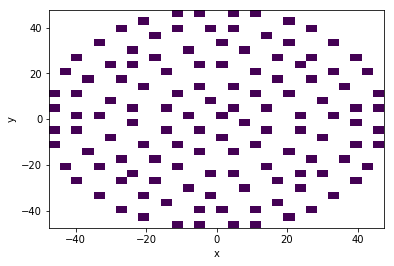

In [14]:
fig, ax = plt.subplots()
#plt.contourf(xhist,yhist,adchist)
ax.hist2d(xhist,yhist, bins=(30,30), norm=mpl.colors.LogNorm())
ax.set_xlabel("x")
ax.set_ylabel("y")
#fname = 'NG_drift10000.png'
#fig.savefig(fname, dpi = (200))

In [34]:
#plotting x,y and adc as hist2d (surly not the best way)
#adc_corrected, x, y, for each PMT for one event
xhist = []
yhist = []
adchist = np.array([])
pmt = eval(config['DEFAULT']['pmts'])

for ch in ch_top:
    if len(list(filter(lambda value:value["channel"]==ch,channellist)))==0:
        newlist = 0
        adchist = np.append(adchist,0)
    else:
        newlist = list(filter(lambda value:value["channel"]==ch,channellist))[0]
        #adchist = np.append(adchist,newlist['adc_corrected']) 
    x = pmt[ch]['position']['x']
    y = pmt[ch]['position']['y'] 
    newlist['adc_corrected'].astype(np.int64)
    print(type(newlist['adc_corrected']))
    #for i in np.linspace(0, newlist['adc_corrected'], num=5):# < newlist['adc_corrected']:
    xhist.append([x for i in range(newlist['adc_corrected'])])
    yhist.append([y for i in range(newlist['adc_corrected'])])


<class 'numpy.float64'>


TypeError: 'int' object is not subscriptable

In [ ]:
fig, ax = plt.subplots()    
ax.hist2d(xhist,yhist, bins=(30,30), norm=mpl.colors.LogNorm())
ax.set_xlabel("x")
ax.set_ylabel("y")
#fname = 'NG_scatterForOneEvent.png'
#fig.savefig(fname, dpi = (200))

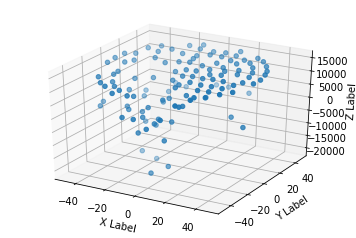

In [187]:
#3d plot
from mpl_toolkits.mplot3d import Axes3D 
ax = plt.subplot(projection='3d')
ax.scatter(xhist, yhist, adchist)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()
